In [1]:
#pip install kumaraswamy  # only depends on numpy
from kumaraswamy import kumaraswamy
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
def flatten(tup):
    """ 
    Flatten any nested tuple
    """
    if len(tup) < 1:
        return tup 
    if isinstance(tup[0], tuple):
        return flatten(tup[0]) + flatten(tup[1:])
    return tup[:1] + flatten(tup[1:])


def calc_shapley_value(player_index, all_players, cf_dict):
    """
    Calculate the Shapley value for player index
    Input:
        all_players, list of player indices
        cf_dict, dictionary containing characteristic function values for all players
    """
    players = all_players.copy()

    if player_index in players:
        players.remove(player_index)

    num_players = len(players)
    coalition_sizes = list(range(num_players+1))
    value = 0
    player_tuple = (player_index,)

    for _size in coalition_sizes:
        coalition_value = 0
        coalitions_of_size_s = list(combinations(players, _size))
        for _coalition in coalitions_of_size_s:
            value_in_coalition = (cf_dict[tuple(sorted(_coalition + player_tuple))] - cf_dict[_coalition])
            coalition_value += value_in_coalition

        average_coalition_value = coalition_value/len(coalitions_of_size_s)
        value += average_coalition_value
    average_value = value/len(coalition_sizes)

    return average_value

def calc_shapley_values(x, y, cf_dict):
    """
    Returns the shapley values for features x and labels y, given a
    characteristic function (default dcor)
    """
    
    players = list(range(x.shape[1]))
    shapley_values = []
    for _player in players:
        shapley_values.append(calc_shapley_value(_player, players, cf_dict))
    return shapley_values

def make_cf_dict(x, y, characteristic_function):
    """ 
    Creates dictionary with values of the characteristic function for each
    combination of the players.
    """
    cf_dict = {}
    num_players = x.shape[1]
    players = list(range(num_players))
    coalition_sizes = list(range(num_players+1))

    for _size in coalition_sizes:
        coalitions_of_size_s = list(combinations(players, _size))
        for _coalition in coalitions_of_size_s:
            _coalition = tuple(sorted(flatten(_coalition)))
            cf_dict[_coalition] = characteristic_function(x, y, _coalition)

    return cf_dict

def characteristic_function_r2(x, y, coalition):
    """
    Returns the characteristic function value (currently the coefficient of determination)
    Input:
        x, numpy array shape (#samples, #features)        
        y, numpy array shape (#samples, )
        coalition, tuple of indices of features to include
    """
    if len(coalition)==0:
        return 0.0
    x = x[:, coalition]
    
    # --- Coefficient of determination, R2
    det_C_xy = np.linalg.det(np.corrcoef(x.T, y))
    
    if len(coalition)==1:
        det_C_x = 1
    else:
        det_C_x = np.linalg.det(np.corrcoef(x.T))
    
    if det_C_xy < np.finfo(float).eps:
        return 1
        
    return (1 - det_C_xy/det_C_x)

def eps():
    """"Returns a single draw from random normal distribution"""
    return np.random.normal(0,1,1)

# Danger zone: Correlated features

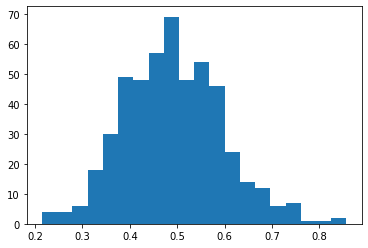

In [3]:
def sample_cause(n_samples):
    return np.random.normal(0.5,0.1, n_samples)
plt.hist(sample_cause(500),bins=20)
plt.show()

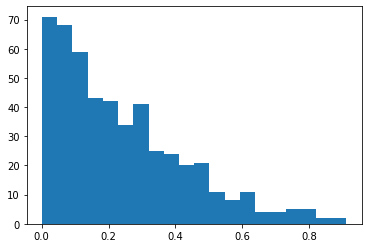

In [4]:
def sample_kumaraswamy(n_samples):
    k = kumaraswamy(a=1, b=3)
    return k.rvs(n_samples)
plt.hist(sample_kumaraswamy(500),bins=20)
plt.show()

In [5]:
# Make the targets
def target(array):
    return array[0] + array[1] + 2*array[2]

In [6]:
# Create x_data and y_data arrays
cause_1 = sample_cause(500)
cause_2 = sample_kumaraswamy(500)
x_data = np.transpose(np.vstack([cause_1, cause_1 + eps(), cause_2 ]))
y_data = np.hstack([target(_x) for _x in x_data])
#print(x_data.shape)
#print(y_data.shape)

In [7]:
# Create characteristic function dictionary
cf_dict = make_cf_dict(x_data, y_data, characteristic_function_r2);

In [8]:
# and calculate Shapley values
calc_shapley_values(x_data, y_data, cf_dict)

[0.06607483884783662, 0.053289346201084296, 0.8806358149510792]

# Top players may be poor performers

In [9]:
cf_dict = {():0,(1,):0,(2,):7,(3,):7,(1,2):10, (1,3):10, (2,3):7,(1,2,3):10}
all_players = [1,2,3]

In [11]:
print(calc_shapley_value(1, all_players, cf_dict))
print(calc_shapley_value(2, all_players, cf_dict))
print(calc_shapley_value(3, all_players, cf_dict))

2.0
4.0
4.0
